In [1]:
!pip install seaborn
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 294 kB 5.4 MB/s eta 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 139 kB 5.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 40.0 MB/s eta 0:00:01
     |████████████████████████████████| 214 kB 120.3 MB/s eta 0:00:01


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from datetime import datetime
#%matplotlib notebook
random_seed = 0
np.random.seed(seed=random_seed)
torch.manual_seed(random_seed)
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
path = os.path.join(os.getcwd(), "plot/")
today=datetime.today().strftime('%Y-%m-%d')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class BaseNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(BaseNetwork, self).__init__()
        layers = []
        if hidden_sizes == []:
            self.model = nn.Linear(input_size, output_size)
        else:
            layers.append(nn.Linear(input_size, hidden_sizes[0]))
            layers.append(nn.ReLU())
            for i in range(1, len(hidden_sizes)):
                layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
                layers.append(nn.ReLU())
            layers.append(nn.Linear(hidden_sizes[-1], output_size))
            self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)
    
class FHatNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FHatNetwork, self).__init__()
        layers = []
        if hidden_sizes == []:
            self.theta = nn.Linear(input_size, output_size)
            self.offset = nn.Linear(input_size, output_size)
    def forward(self, x):
        return torch.sin(self.theta(x))+self.offset(x)


# Define the hypernetwork
class HyperNetwork(nn.Module):
    def __init__(self, input_dim):
        super(HyperNetwork, self).__init__()
        self.input_dim = input_dim
        self.hyper_theta = BaseNetwork(1,[10],input_dim)
        self.hyper_offset = BaseNetwork(1,[10],input_dim)
    def forward(self, alpha):
        alpha = alpha.unsqueeze(0)
        theta = torch.tanh(self.hyper_theta(alpha))
        theta = theta.view(self.input_dim, 1)
        offset = torch.tanh(self.hyper_offset(alpha))
        offset = offset.view(self.input_dim, 1)
        return theta, offset
    
    def compute(self, x, alpha):
        theta, offset = self.forward(alpha)
        return torch.sin(x@theta)+x@offset

**Preliminaries** In the following, the classes are defined to initiate the aggregation functions $\rho_{\alpha}$ and the aggregated risk minimization (ARM) optimization for a simple 1D and 2D regression task.

In [6]:
class aggregation_function:    
    """ This class aggregates the risks. """
    def __init__(self, name:str):
        self.name = name
    def aggregate(self, risks, alpha) -> float:
        if self.name == 'cvar':
            return self.cvar(risks, alpha)
        elif self.name == 'quantile':
            return self.quantile(risks, alpha)
        else:
            raise NotImplementedError("Currently, only CVaR is implemented.")
   
    def quantile(self, risks, alpha) -> float:
        var = torch.quantile(risks,alpha, interpolation='linear')
        return var
    
    def cvar(self, risks, alpha) -> float:
        var = torch.quantile(risks,alpha, interpolation='linear')
        cvar = risks[risks > var].mean()
        return cvar

In [7]:
class ARM_Regression:
    def __init__(self, name, experiment="1D_linear"):      
        self.aggregator = aggregation_function(name=name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def avg_cvar(self, f, env_dict, loss_fn, alphas, augmented_hypothesis=True):
        if augmented_hypothesis == False:
            risks = torch.stack([loss_fn(env_dict[e]['y'].to(device),f(env_dict[e]['x'].to(device))) for e in env_dict.keys()])
            cvar_estimates = [self.aggregator.aggregate(risks, alpha) for alpha in alphas]
            cvar_estimates = torch.stack(cvar_estimates)
            average_cvar = torch.mean(cvar_estimates)
            return average_cvar
        else:
            cvar_estimates = []
            for alpha in alphas:
                risks = [loss_fn(env_dict[e]['y'].to(device),f.compute(env_dict[e]['x'].to(device), alpha)) for e in env_dict.keys()]
                risks = torch.stack(risks)
                cvar_sample = self.aggregator.aggregate(risks, alpha)
                cvar_estimates.append(cvar_sample)
            cvar_estimates = torch.stack(cvar_estimates)
            average_cvar = torch.mean(cvar_estimates)
            return average_cvar
    
    def train_together(self, f, env_dict, dist="uniform", true_alpha=0.5):
        learning_rate = 0.1
        num_epochs= 100
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(f.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
        if dist == "uniform":
            alphas = np.random.uniform(low=0, high=1, size=20)
            alphas = torch.tensor(alphas, dtype=torch.float32).to(self.device)
        else:
            # Generate samples from a normal distribution
            alphas = torch.normal(mean=true_alpha, std=1.0, size=(20,))
            alphas = torch.clamp(alphas, min=0.0, max=1).to(self.device)
            
        for epoch in range(num_epochs):
            avg_cvar = self.avg_cvar(f, env_dict, loss_fn, alphas, augmented_hypothesis=False)
            avg_cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_cvar.item()}")
        return 

    def fit_h_new(self, h, env_dict):
        learning_rate = 0.1
        num_epochs= 100
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
        alphas = np.random.uniform(low=0, high=1, size=20)
        print(alphas)
        alphas = torch.tensor(alphas, dtype=torch.float32).to(self.device)
        for epoch in range(num_epochs):
            avg_cvar = self.avg_cvar(h, env_dict, loss_fn, alphas, augmented_hypothesis=True)
            avg_cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_cvar.item()}")
        return 
    
    def fit_f(self, f, env_dict, alpha):        
        learning_rate = 0.1
        num_epochs= 100
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(f.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
        for epoch in range(num_epochs):
            risks = torch.stack([loss_fn(env_dict[e]['y'].to(self.device),f(env_dict[e]['x'].to(self.device))) for e in env_dict.keys()])
            cvar = self.aggregator.aggregate(risks, alpha)
            cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return 
    

**Experiment 1** We assume the following *linear* data generation process $$Y(X) = X*\theta_{e}+\epsilon$$ and *nonlinear* data generation process $$Y(X) = sin(X*\theta_{e})+\epsilon$$.

**Experiment 1A** Assume a linear model $Y_{e}=\theta_{e}X+\epsilon$, where $X \sim \mathcal{N}(2,0.2)$ and $\epsilon\sim \mathcal{N}(0,0.1)$. We simulate different environments by drawing $\theta$ from a beta distribution $Beta(0.1,0.2)$. In total, we generate for 25 environments 100 observations each.

**Experiment 1B** Assume the same setting as in Experiment 1, however, in contrast, we simulate different environments by drawing $\theta$ from a uniform distribution $\ \mathcal{U}(0,1)$. In total, we generate for 25 environments 100 observations each.

In [8]:
class data_generator:
    
    """ This class generates the simulation data. """
    

    def __init__(self, envs_train = 25, envs_test = 25, 
                 size_train = 1000, size_test= 100, 
                 theta_dist="uniform",
                 dim=1):
        
        self.envs_train = envs_train
        self.envs_test = envs_test
        self.size_train = size_train
        self.size_test = size_test
        self.theta_dist = theta_dist
        self.dim = dim 
        
    def generate(self) -> dict:           
        env_list_train = [f'e_{i}' for i in range(1,self.envs_train+1,1)]
        env_dict_train = dict(list(enumerate(env_list_train)))
        env_list_test  = [f'e_{i}' for i in range(1,self.envs_test+1,1)]
        env_dict_test  = dict(list(enumerate(env_list_test)))
        
        
        for e_train in env_dict_train.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(1, 2)
            else:
                distribution = dist.Beta(0.1, 0.2)
            theta_true = distribution.sample((self.dim,1))
            x_train = torch.tensor(np.linspace(0, 1.5, self.size_train))
            noise_std = np.linspace(1.2, 0.2, self.size_train)
            noise_train = torch.tensor(np.random.normal(0, noise_std))
            sine_signal = torch.sin(2*np.pi*x_train)
            sine_envelop = torch.sin((2/3)*np.pi*x_train)
            final_signal = sine_envelop*sine_signal
            y_train = final_signal + noise_train + theta_true.item()
            x_train, y_train = x_train.unsqueeze(1), y_train.unsqueeze(1)
            env_dict_train[e_train] = {'x': x_train.float(),'y': y_train.float(),'theta_true': theta_true}
            
        for e_test in env_dict_test.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0.9, 1.1)
            else:
                distribution = dist.Beta(0.1, 0.2)
            theta_true = distribution.sample((self.dim,1))
            x_test = torch.tensor(np.linspace(0, 1.5, self.size_test))
            noise_std = np.linspace(1.2, 0.2, self.size_test)
            noise_test = torch.tensor(np.random.normal(0, noise_std))
            sine_signal = torch.sin((1.0/math.sqrt(self.dim))*2 * np.pi*x_test)
            sine_envelop = torch.sin((1.0/math.sqrt(self.dim))*(2/3)* np.pi*x_test)
            y_test = sine_envelop*sine_signal + noise_test + theta_true.item()
            x_test, y_test = x_test.unsqueeze(1), y_test.unsqueeze(1)
            env_dict_test[e_test] = {'x': x_test.to(torch.float32),'y': y_test.to(torch.float32),'theta_true': theta_true}
            
        return env_dict_train, env_dict_test

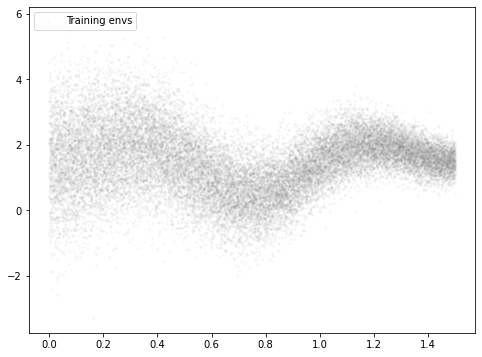

In [9]:
# Intitialize the experiment and generate the data
dim=1 
rho="cvar"
envs_train, envs_test = 25, 25
size_train, size_test = 1000 , 1000
theta_dist="uniform" 
# Define some example dimensions
generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()
fig, ax = plt.subplots(1,1, figsize=(8,6))

X_train = [data_dict_train[e]['x'].ravel() for e in data_dict_train.keys()]
X_train = np.array([item for sublist in X_train for item in sublist]).reshape(-1,1)
Y_train = [data_dict_train[e]['y'] for e in data_dict_train.keys()]
Y_train = np.array([item for sublist in Y_train for item in sublist]).reshape(-1,1)

ax.scatter(y=Y_train, x=X_train, s=3, c="grey", alpha=0.05, label="Training envs")
ax.legend(loc='upper left')

In [10]:
import copy
def fixed(data_dict_train, dim, alphas):
    h = HyperNetwork(dim).to(device)
    ARM_Regression(name="cvar").fit_h_new(h, data_dict_train)
    
    f = FHatNetwork(dim,[],1).to(device)
    ARM_Regression(name="cvar").train_together(f, data_dict_train, dist="uniform")
    f_unif = copy.deepcopy(f)
    
    groundtruths = []
    for alpha in alphas:
        ARM_Regression(name="cvar").fit_f(f, data_dict_train, alpha)
        groundtruths.append(copy.deepcopy(f))
        
    ARM_Regression(name="quantile").fit_f(f, data_dict_train, 0.5)
    f_med = copy.deepcopy(f)
    
    ARM_Regression(name="cvar").fit_f(f, data_dict_train, 0.0)
    f_avg = copy.deepcopy(f)
    
    ARM_Regression(name="cvar").fit_f(f, data_dict_train, 0.999)
    f_worse = copy.deepcopy(f)
    
    return f_unif, f_med, groundtruths, f_avg, f_worse, h

In [11]:
def execute(true_alpha, f_unif, f_med, h, ground_truth_f, f_avg, f_worse, data_dict_test):
    loss_fn = torch.nn.MSELoss()
    with torch.no_grad():
        train_risks = []
        for e in data_dict_test.keys():
            x, y = data_dict_test[e]['x'].to(device), data_dict_test[e]['y'].to(device)
            train_risks.append(loss_fn(y, ground_truth_f(x)).cpu()) 
        train_risks = torch.stack(train_risks)
    groundtruth_cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)

    with torch.no_grad():
        train_risks = []
        for e in data_dict_test.keys():
            x, y = data_dict_test[e]['x'].to(device), data_dict_test[e]['y'].to(device)
            train_risks.append(loss_fn(y, f_unif(x)).cpu()) 
        train_risks = torch.stack(train_risks)
    uniform_cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)


    with torch.no_grad():
        train_risks = []
        for e in data_dict_test.keys():
            x, y = data_dict_test[e]['x'].to(device), data_dict_test[e]['y'].to(device)
            train_risks.append(loss_fn(y, f_med(x)).cpu()) 
        train_risks = torch.stack(train_risks)
    med_cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)
    
    with torch.no_grad():
        train_risks = []
        for e in data_dict_test.keys():
            x, y = data_dict_test[e]['x'].to(device), data_dict_test[e]['y'].to(device)
            train_risks.append(loss_fn(y, f_avg(x)).cpu()) 
        train_risks = torch.stack(train_risks)
    avg_cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)
    
    with torch.no_grad():
        train_risks = []
        for e in data_dict_test.keys():
            x, y = data_dict_test[e]['x'].to(device), data_dict_test[e]['y'].to(device)
            train_risks.append(loss_fn(y, f_worse(x)).cpu()) 
        train_risks = torch.stack(train_risks)
    worse_cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)
    
    
    with torch.no_grad():
        train_risks = []
        for e in data_dict_test.keys():
            x, y = data_dict_test[e]['x'].to(device), data_dict_test[e]['y'].to(device)
            train_risks.append(loss_fn(y, h.compute(x,torch.tensor(true_alpha).to(device))).cpu()) 
        train_risks = torch.stack(train_risks)
    our_cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)
    return groundtruth_cvar.item(), med_cvar.item(), uniform_cvar.item(), avg_cvar.item(), worse_cvar.item(), our_cvar.item()

In [ ]:
# New function to reset seeds and reinitialize models
def reinitialize_models(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    f_unif, f_dirac, ground_truths, f_avg, f_worse, h = fixed(data_dict_train, dim, true_alphas)
    return f_unif, f_dirac, ground_truths, f_avg, f_worse, h

# Main loop for iterating over different seeds
num_seeds = [1,2,3,4,5,6,7,8]  # Number of different seeds to use
true_alphas = [0.0, 0.1, 0.2, 0.4, 0.3, 0.5, 0.7, 0.8, 0.9, 0.999]
results = {str(true_alpha): {"GT": [], "Med": [], "Unif": [], "Our": [], "Avg": [], "Worse": []} for true_alpha in true_alphas}

for seed in num_seeds:
    # Reinitialize models with the new seed
    f_unif, f_med, ground_truths, f_avg, f_worse, h = reinitialize_models(seed)
    
    for index in range(len(true_alphas)):
        ground_truth, med, uniform, avg, worse, our = execute(true_alphas[index], f_unif, f_med, h, ground_truths[index], f_avg, f_worse, data_dict_test)    
        # Collecting the results
        results[str(true_alphas[index])]["GT"].append(ground_truth)
        results[str(true_alphas[index])]["Med"].append(med)
        results[str(true_alphas[index])]["Unif"].append(uniform)
        results[str(true_alphas[index])]["Our"].append(our)
        results[str(true_alphas[index])]["Avg"].append(avg)
        results[str(true_alphas[index])]["Worse"].append(worse)

[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01
 1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01
 3.96767474e-01 5.38816734e-01 4.19194514e-01 6.85219500e-01
 2.04452250e-01 8.78117436e-01 2.73875932e-02 6.70467510e-01
 4.17304802e-01 5.58689828e-01 1.40386939e-01 1.98101489e-01]
Epoch [10/100], Loss: 1.518517255783081
Epoch [20/100], Loss: 1.5204379558563232
Epoch [30/100], Loss: 1.5205944776535034
Epoch [40/100], Loss: 1.520624041557312
Epoch [50/100], Loss: 1.5206266641616821
Epoch [60/100], Loss: 1.5206211805343628
Epoch [70/100], Loss: 1.5206124782562256
Epoch [80/100], Loss: 1.5206024646759033
Epoch [90/100], Loss: 1.520591378211975
Epoch [100/100], Loss: 1.5205798149108887
Epoch [10/100], Loss: 1.16177237033844
Epoch [20/100], Loss: 1.0667461156845093
Epoch [30/100], Loss: 0.9702938199043274
Epoch [40/100], Loss: 0.9717855453491211
Epoch [50/100], Loss: 0.9651992917060852
Epoch [60/100], Loss: 0.964023232460022
Epoch [70/100], Loss: 0.9631404876708984
Ep

Epoch [10/100], Loss: 1.5612293481826782


In [ ]:
def compute_statistics(results):
    means = {}
    std_devs = {}

    for key, value in results.items():
        # Ensure value is a list of numbers, not a dictionary
        if isinstance(value, dict):
            means[key] = {sub_key: np.mean(sub_value) for sub_key, sub_value in value.items()}
            std_devs[key] = {sub_key: np.std(sub_value) for sub_key, sub_value in value.items()}
        else:
            means[key] = np.mean(value)
            std_devs[key] = np.std(value)

    return means, std_devs
means, std_devs = compute_statistics(results)

In [ ]:
print("GT")
for key in results.keys():
    print(means[key]['GT'],std_devs[key]['GT'])
print("---------------")
print("Med")
for key in results.keys():
    print(means[key]["Med"],std_devs[key]["Med"])
print("---------------")
print("Unif")
for key in results.keys():
    print(means[key]["Unif"],std_devs[key]["Unif"])
print("---------------")
print("Avg")
for key in results.keys():
    print(means[key]["Avg"],std_devs[key]["Avg"])
print("---------------")
print("Worse")
for key in results.keys():
    print(means[key]["Worse"],std_devs[key]["Worse"])
print("---------------")
print("Our")
for key in results.keys():
    print(means[key]["Our"],std_devs[key]["Our"])
print("---------------")